* **[Phase 1 - Data Collection and Visualization](#phase1)**
   - [Imports & Installations](#import)
   - [Data Loading](#step01)   
   - [Data Parsing & Cleaning](#step02)  
   - [Data Flattening](#step03)  
   - [Exporting Data to Excel](#step04)  

* **[Phase 2 - Data Storage and Processing Pipeline](#phase2)**
   - [creating database and importing data](#step11)
   - [Database Queries and Explorations](#step12)
   - [Review Initial Insights (EDA)](#step13)
   - [Perform Advanced Feature Engineering](#step14)
   - [Image Data Preprocessing and Visual Feature Extraction](#step15)
   - [Comprehensive Data Preprocessing](#step16)
   - [Blurry Image Detection and Labeling](#step17)
   - [Blurry Image Statics](#step21)
   - [Creating an AI Pipeline](#step18)
   - [General Overview of the Database](#step19)
   - [CI/CD  Implementation](#step20)
* **[Phase 3 - Final Conclusions and Model Development](#phase3)**


<a id='phase1'></a>
## **Phase 1 - Data Collection and Visualization**

<a id='import'></a>
### **Imports & Installations**

In [8]:
# !pip install kagglehub
# !pip install openpyxl

In [9]:
import xml.etree.ElementTree as ET
# import kagglehub
import os
import pandas as pd

<a id='step01'></a>
### **Data Loading**

In [10]:
path_to_dataset = "content"
"""
If the dataset is not downloaded to your local machine you can use the following
commented command:
"""
# path_to_dataset = kagglehub.dataset_download("andrewmvd/car-plate-detection")

annotation_folder = os.path.join(path_to_dataset, "annotations")
image_folder = os.path.join(path_to_dataset, "images")



<a id='step02'></a>
### **Data Parsing & Cleaning**

In [11]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = {
        'width': int(root.find('size/width').text),
        'height': int(root.find('size/height').text)
    }

    objects = []
    for obj in root.findall('object'):
        bndbox = {
            'xmin': int(obj.find('bndbox/xmin').text),
            'ymin': int(obj.find('bndbox/ymin').text),
            'xmax': int(obj.find('bndbox/xmax').text),
            'ymax': int(obj.find('bndbox/ymax').text),
        }
        ocr_text_elem = obj.find('ocr_text')
        worth_ocr_elem = obj.find('worth_ocr')

        bndbox['ocr_text'] = ocr_text_elem.text if ocr_text_elem is not None else None
        bndbox['worth_ocr'] = int(worth_ocr_elem.text) if worth_ocr_elem is not None else None

        objects.append(bndbox)

    return {
        'folder': root.find('folder').text,
        'filename': root.find('filename').text,
        'size': size,
        'objects': objects
    }

<a id='step03'></a>
### **Data Flattening**

In [12]:
records = []

for file in os.listdir(annotation_folder):
    if file.endswith(".xml"):
        parsed = parse_xml(os.path.join(annotation_folder, file))
        for obj in parsed['objects']:
            records.append({
                'filename': parsed['filename'],
                'folder': parsed['folder'],
                'width': parsed['size']['width'],
                'height': parsed['size']['height'],
                'xmin': obj['xmin'],
                'ymin': obj['ymin'],
                'xmax': obj['xmax'],
                'ymax': obj['ymax'],
                'ocr_text': obj.get('ocr_text'),
                'worth_ocr': obj.get('worth_ocr')
            })



<a id='step04'></a>
### **Exporting Data to Excel**

In [13]:
df = pd.DataFrame(records)
excel_path = os.path.join('content', 'car_plate_annotations.xlsx')
df.to_excel(excel_path, index=False)

print(f"Data exported successfully to {excel_path}")

Data exported successfully to content\car_plate_annotations.xlsx


<a id='phase2'></a>
## **Phase 2 - Data Storage and Processing Pipeline**

<a id='step11'></a>
### **creating database and importing data**

In [14]:
import sqlite3
import pandas as pd





os.makedirs('database', exist_ok=True)




df = pd.read_excel(excel_path)

df['image_path'] = df['filename'].apply(lambda x: os.path.join('content', 'images', x))


db_path = os.path.join('database', 'dataset.db')


conn = sqlite3.connect(db_path)

conn.execute('''
CREATE TABLE IF NOT EXISTS image_annotations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    filename TEXT NOT NULL,
    folder TEXT NOT NULL,
    width INTEGER NOT NULL,
    height INTEGER NOT NULL,
    xmin INTEGER NOT NULL,
    ymin INTEGER NOT NULL,
    xmax INTEGER NOT NULL,
    ymax INTEGER NOT NULL,
    image_path TEXT NOT NULL,
    UNIQUE(filename) 
);
''')


df.to_sql(
    name='image_annotations',
    con=conn,
    if_exists='replace',
    index=False,
    dtype={
        'filename': 'TEXT',
        'folder': 'TEXT',
        'width': 'INTEGER',
        'height': 'INTEGER',
        'xmin': 'INTEGER',
        'ymin': 'INTEGER',
        'xmax': 'INTEGER',
        'ymax': 'INTEGER',
        'image_path': 'TEXT'
    }
)
conn.commit()
conn.close()


print("✅ Initial database created.")


✅ Initial database created.


<a id='step12'></a>
### **Database Queries and Explorations**

This script performs exploratory analysis on `image_annotations` table from the local SQLite database (`dataset.db`). Below are the queries and their purposes:


1. General Data Overview
Displays the **first 20 records** from the `image_annotations` table to provide a quick glimpse of the dataset.

2. Top 15 Biggest Plates by Area
Calculates bounding box area and lists the **top 15 plates** with the **largest bounding box areas**.

3. Top 10 Largest Images by Dimensions
Ranks images based on their overall resolution (`width * height`) and lists the **10 largest images**.

4. Plates with Unusual Aspect Ratios
Identifies the **top 10 plates** where the **aspect ratio (width/height)** is **less than 0.5**, indicating potentially distorted or anomalous annotations.

In [15]:
import sqlite3
import pandas as pd


conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Query 1: General data overview (first 20 records)
print("\n=== GENERAL DATA OVERVIEW (first 20 records) ===")
cursor.execute("SELECT * FROM image_annotations LIMIT 20")
general_data = cursor.fetchall()
for row in general_data:
    print(row)

# Query 2: Top 15 biggest plates by area
print("\n=== TOP 15 BIGGEST PLATES BY AREA ===")
cursor.execute("""
    SELECT filename, (xmax-xmin)*(ymax-ymin) as area 
    FROM image_annotations 
    ORDER BY area DESC 
    LIMIT 15
""")
top_plates = cursor.fetchall()
for plate in top_plates:
    print(f"File: {plate[0]}, Area: {plate[1]} pixels")

# Query 3: Top 10 largest pictures overall (by image dimensions)
print("\n=== TOP 10 LARGEST PICTURES (BY DIMENSIONS) ===")
cursor.execute("""
    SELECT filename, width, height 
    FROM image_annotations 
    ORDER BY (width * height) DESC 
    LIMIT 10
""")
big_pics = cursor.fetchall()
for pic in big_pics:
    print(f"File: {pic[0]}, Size: {pic[1]}x{pic[2]} pixels")


# Query 4: Plates with small aspect ratios (potential anomalies)
print("\n=== PLATES WITH UNUSUAL ASPECT RATIOS (<0.5) ===")
cursor.execute("""
    SELECT filename, 
           (xmax-xmin)/(ymax-ymin) as aspect_ratio
    FROM image_annotations
    WHERE (xmax-xmin)/(ymax-ymin) < 0.5
    ORDER BY ABS(1.0 - (xmax-xmin)/(ymax-ymin)) DESC LIMIT 10
""")
weird_plates = cursor.fetchall()
for plate in weird_plates:
    print(f"File: {plate[0]}, Aspect Ratio: {plate[1]:.2f}")

conn.close()


=== GENERAL DATA OVERVIEW (first 20 records) ===
('Cars0.png', 'images', 500, 268, 226, 125, 419, 173, 'KLG1CA2555', 1.0, 'content\\images\\Cars0.png')
('Cars1.png', 'images', 400, 248, 134, 128, 262, 160, 'PGoMN112', 1.0, 'content\\images\\Cars1.png')
('Cars10.png', 'images', 400, 225, 140, 5, 303, 148, '[NO TEXT]', 0.0, 'content\\images\\Cars10.png')
('Cars100.png', 'images', 400, 267, 175, 114, 214, 131, '[NO TEXT]', 0.0, 'content\\images\\Cars100.png')
('Cars101.png', 'images', 400, 300, 167, 202, 240, 220, 'HR 26 BC 55I4', 1.0, 'content\\images\\Cars101.png')
('Cars102.png', 'images', 350, 263, 66, 147, 322, 199, '6861136', 1.0, 'content\\images\\Cars102.png')
('Cars103.png', 'images', 400, 196, 230, 129, 248, 134, '[NO TEXT]', 0.0, 'content\\images\\Cars103.png')
('Cars103.png', 'images', 400, 196, 189, 116, 202, 121, None, None, 'content\\images\\Cars103.png')
('Cars104.png', 'images', 500, 374, 195, 266, 244, 282, 'NL60LXB', 1.0, 'content\\images\\Cars104.png')
('Cars105.png',

<a id='step13'></a>
### **Review Initial Insights (EDA)**

- **Plot 1:**  
  Many images fall around the 400 × 400 pixel size range.

- **Plot 2:**  
  License plate lengths range from 0 to 100 pixels, and widths range from 0 to 50 pixels.

- **Plot 3:**  
  The area of most plates is around 1000 pixels² (showing an exponential-like distribution).

- **Plot 4:**  
  Most images have exactly one detected plate (about %86.6).


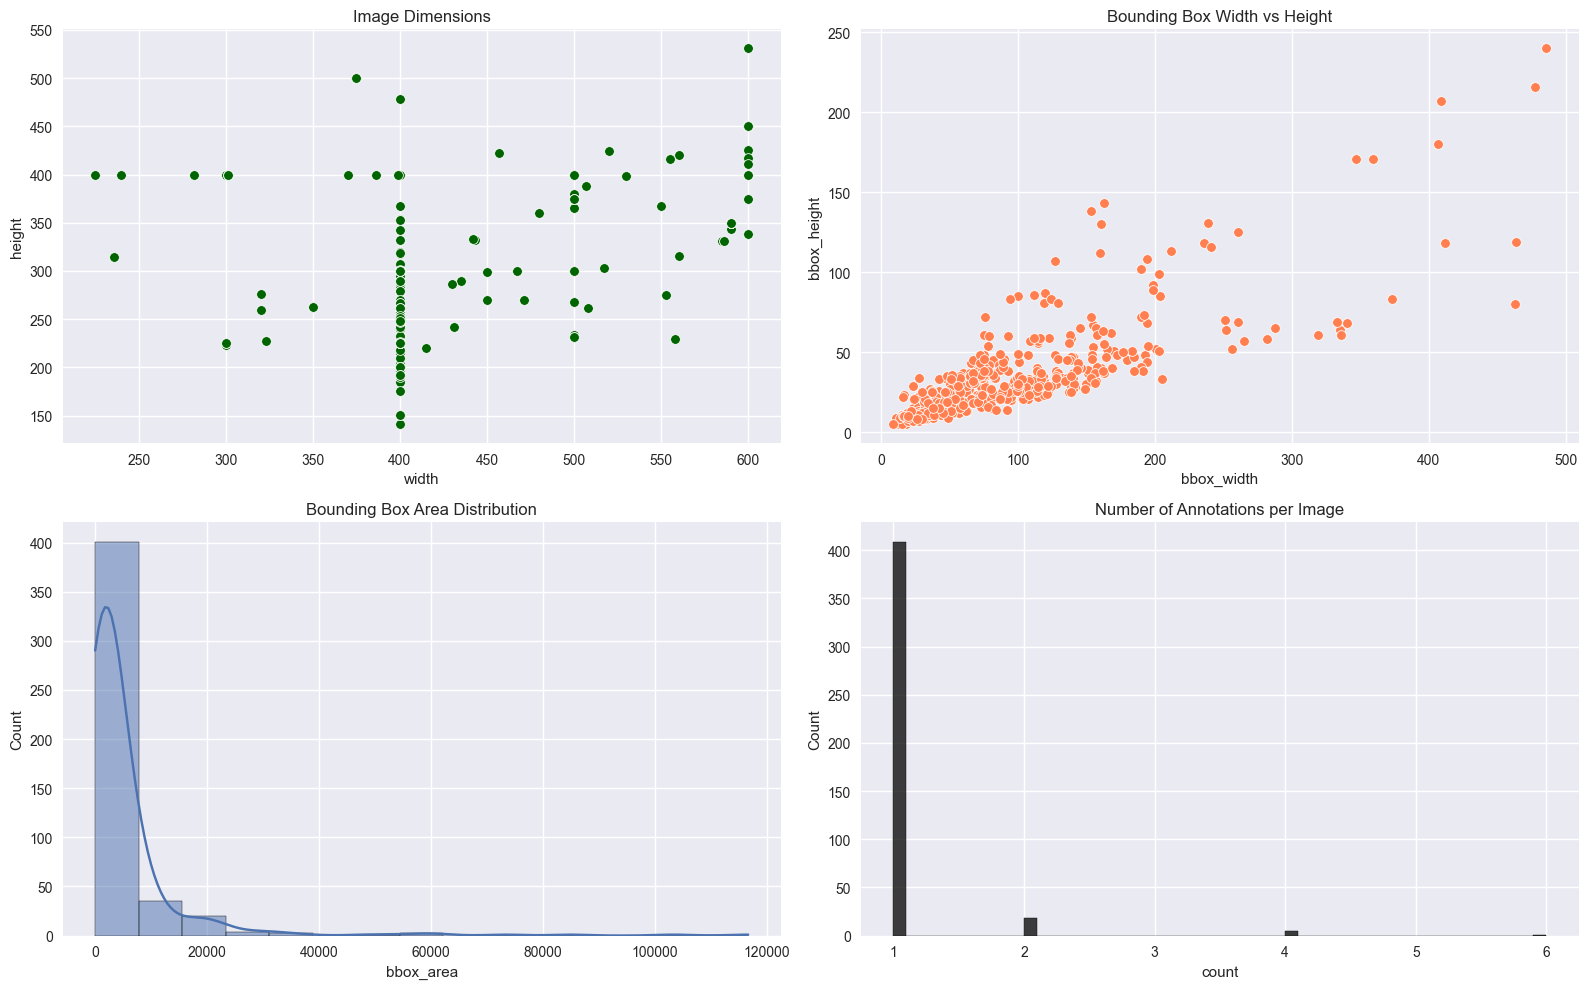

In [16]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')


conn = sqlite3.connect(db_path)

df = pd.read_sql_query("SELECT * FROM image_annotations", conn)

conn.close()

df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='width', y='height', data=df, color='darkgreen')
plt.title("Image Dimensions")

plt.subplot(2, 2, 2)
sns.scatterplot(x='bbox_width', y='bbox_height', data=df, color='coral')
plt.title("Bounding Box Width vs Height")

plt.subplot(2, 2, 3)
sns.histplot(df['bbox_area'], bins=15, kde=True)
plt.title("Bounding Box Area Distribution")

plt.subplot(2, 2, 4)
annotation_counts = df['filename'].value_counts()
sns.histplot(annotation_counts, bins=50, color='black')
plt.title("Number of Annotations per Image")

plt.tight_layout()
plt.show()


<a id='step14'></a>
### **Perform Advanced Feature Engineering**

we engineered several visual and spatial features to aid OCR-based modeling. These features help normalize input, understand plate positioning, and assess visual scale and alignment across the dataset.

We created the following advanced features:

- **`bbox_width` and `bbox_height`**: The pixel width and height of each annotated plate, calculated as `xmax - xmin` and `ymax - ymin`. These are important for detecting elongated or squished plates.

- **`bbox_area`**: The area (in pixels) of the plate region, helping detect abnormal sizes that may affect OCR accuracy.

- **`aspect_ratio`**: Computed as `bbox_width / bbox_height`, indicating the geometric proportions of the plate. This is crucial since license plates typically follow consistent formats (e.g., 4:1 width-to-height ratio).

- **`area_fraction`**: The proportion of the image covered by the plate (`bbox_area / (width * height)`). Helps understand scale and whether plates are zoomed-in or distant.

- **`center_x_norm` and `center_y_norm`**: The normalized center coordinates of each bounding box, giving insight into spatial distribution and plate alignment (values between 0 and 1).

- **`margin_left`, `margin_right`, `margin_top`, `margin_bottom`**: Distance (in pixels) from the plate edges to the image borders. Useful for analyzing whether plates are centered or edge-aligned.

These features collectively provide rich information about the visual and spatial properties of plates. They will support the **OCR preprocessing pipeline** in the next phase by enabling:

- Selection of consistent plate crops for input into OCR models.
- Filtering or augmenting images with small, poorly framed, or off-centered plates.
- Data quality checks for outlier bounding boxes before modeling.



In [17]:
import sqlite3
import pandas as pd

# Basic derived features
df['bbox_width']  = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area']   = df['bbox_width'] * df['bbox_height']

# Aspect ratio of each bounding box
df['aspect_ratio'] = df['bbox_width'] / df['bbox_height']

# Fraction of image covered by the plate
df['area_fraction'] = df['bbox_area'] / (df['width'] * df['height'])

# Normalized center coordinates (useful for spatial models)
df['center_x_norm'] = ((df['xmin'] + df['xmax']) / 2) / df['width']
df['center_y_norm'] = ((df['ymin'] + df['ymax']) / 2) / df['height']

# Edge margins (distance from plate to each image border)
df['margin_left']   = df['xmin']
df['margin_top']    = df['ymin']
df['margin_right']  = df['width']  - df['xmax']
df['margin_bottom'] = df['height'] - df['ymax']

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

conn.execute('''
CREATE TABLE IF NOT EXISTS engineered_plate_features (
    id INTEGER PRIMARY KEY AUTOINCREMENT,  -- Auto-incremented primary key
    filename TEXT NOT NULL,
    bbox_width REAL NOT NULL,
    bbox_height REAL NOT NULL,
    bbox_area REAL NOT NULL,
    aspect_ratio REAL NOT NULL,
    area_fraction REAL NOT NULL,
    center_x_norm REAL NOT NULL,
    center_y_norm REAL NOT NULL,
    margin_left INTEGER NOT NULL,
    margin_top INTEGER NOT NULL,
    margin_right INTEGER NOT NULL,
    margin_bottom INTEGER NOT NULL,
    FOREIGN KEY(filename) REFERENCES image_annotations(filename)  -- Foreign key to image_annotations table
);
''')

df[['filename', 'bbox_width', 'bbox_height', 'bbox_area', 'aspect_ratio', 
    'area_fraction', 'center_x_norm', 'center_y_norm', 'margin_left', 
    'margin_top', 'margin_right', 'margin_bottom']].to_sql(
    name='engineered_plate_features',
    con=conn,
    if_exists='replace',  
    index=False
)

conn.commit()
conn.close()


<a id='step15'></a>
### **Image Data Preprocessing and Visual Feature Extraction**

To prepare the plate regions for modeling, we performed the following:

- **Cropping**: Each license plate was cropped using its bounding box.
- **Resizing**: Standardized to 128×32 pixels to ensure consistent model input.
- **Normalization**: Pixel values scaled to the [0.0, 1.0] range.
- **Grayscale conversion**: Reduced noise and simplified feature space.

These steps ensure that all plate images are uniform and suitable for OCR or classification in downstream modeling tasks.

In [18]:
import os
import cv2

# Load data from the database
conn = sqlite3.connect(db_path)
query = """
SELECT 
    p.filename, p.image_path, 
    p.xmin, p.ymin, p.xmax, p.ymax,
    f.bbox_width, f.bbox_height
FROM image_annotations AS p
JOIN engineered_plate_features AS f
  ON p.filename = f.filename
"""
df = pd.read_sql_query(query, conn)
conn.close()

output_folder = 'content/plates'
os.makedirs(output_folder, exist_ok=True)

mean_w = int(df['bbox_width'].mean())
mean_h = int(df['bbox_height'].mean())
output_size = (mean_w, mean_h)

df['preprocessed_plate'] = None
df['preprocessed_folder'] = output_folder

for idx, row in df.iterrows():
    img_path = row['image_path']
    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ Could not read image: {img_path}")
        continue

    # Crop and preprocess
    x0, y0, x1, y1 = row[['xmin','ymin','xmax','ymax']]
    cropped = image[y0:y1, x0:x1]
    resized = cv2.resize(cropped, output_size)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    norm = (gray.astype('float32') / 255.0 * 255).astype('uint8')

    # Save the image
    plate_name = f'plate_{idx:04d}.png'
    save_path = os.path.join(output_folder, plate_name)
    cv2.imwrite(save_path, norm)

    # Store file info in DataFrame
    df.at[idx, 'preprocessed_plate'] = plate_name

print("✅ Plates saved and names assigned.")


✅ Plates saved and names assigned.


In [19]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN preprocessed_plate TEXT;")
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN preprocessed_folder TEXT;")
except sqlite3.OperationalError:
    pass

conn.commit()

for _, row in df.iterrows():
    cursor.execute("""
        UPDATE engineered_plate_features
        SET preprocessed_plate = ?, preprocessed_folder = ?
        WHERE filename = ?
    """, (row['preprocessed_plate'], row['preprocessed_folder'], row['filename']))

conn.commit()
conn.close()

print("✅ Database table 'engineered_plate_features' updated with new file info.")

✅ Database table 'engineered_plate_features' updated with new file info.


<a id='step16'></a>
### **Comprehensive Data Preprocessing**

To ensure clean and model-ready data, we conducted the following preprocessing steps:

- **Removal of No-Plate Entries**: A number of records in the dataset were found to contain no valid license plate annotations, indicated by all bounding box coordinates being zero. These entries were removed from the dataset before feature engineering and database insertion to prevent invalid computations and ensure data integrity.

- **Feature Normalization**: Key numeric features (bounding box sizes, aspect ratio, spatial location) were normalized to [0, 1] using Min-Max scaling. This prevents scale dominance in distance-based models.

- **Redundant Feature Removal**: Features with high pairwise correlation  were dropped after statistical analysis to avoid multicollinearity.

- **Blurry Image Labeling**: All preprocessed plate images were analyzed for sharpness using Laplacian variance. Plates with low blur scores were marked as blurry (`is_blurry = 1`) and stored in the database. This allows for selective filtering of low-quality samples during OCR training or evaluation, without discarding them entirely.


This step ensures the dataset is consistent, scaled, and relevant for downstream modeling tasks like OCR.

**Removal of No-Plate Entries**

In [20]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Delete rows where there is no plate (bounding box size is zero)
cursor.execute("""
    DELETE FROM image_annotations
    WHERE xmin = 0 AND ymin = 0 AND xmax = 0 AND ymax = 0;
""")

conn.commit()
conn.close()

**Feature Normalization**

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Load raw + feature data with a JOIN
conn = sqlite3.connect(db_path)
query = """
SELECT 
    p.filename, p.image_path, 
    p.xmin, p.ymin, p.xmax, p.ymax,
    f.bbox_width, f.bbox_height,
    f.bbox_area, f.aspect_ratio, f.area_fraction,
    f.center_x_norm, f.center_y_norm
FROM image_annotations AS p
JOIN engineered_plate_features AS f
  ON p.filename = f.filename
"""
df = pd.read_sql_query(query, conn)
conn.close()

# Scale the numeric columns
scaler = MinMaxScaler()
cols_to_scale = ['bbox_width', 'bbox_height', 'bbox_area', 'aspect_ratio', 
                 'area_fraction', 'center_x_norm', 'center_y_norm']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


**Redundant Feature Removal**

We computed the pairwise correlations among our 11 numerical features.  

In [22]:
import numpy as np

conn = sqlite3.connect(db_path)
query = """
SELECT 
    p.filename, p.image_path, 
    p.xmin, p.ymin, p.xmax, p.ymax,
    f.bbox_width, f.bbox_height,
    f.bbox_area, f.aspect_ratio, f.area_fraction,
    f.center_x_norm, f.center_y_norm, f.margin_top,
    f.margin_left, margin_right, margin_bottom
FROM image_annotations AS p
JOIN engineered_plate_features AS f
  ON p.filename = f.filename
"""
df = pd.read_sql_query(query, conn)
conn.close()

cols = ['bbox_width','bbox_height','bbox_area',
        'aspect_ratio','area_fraction',
        'center_x_norm','center_y_norm',
        'margin_left','margin_top','margin_right','margin_bottom']

corr = df[cols].corr().abs()

corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)
print(corr_pairs.head(10))


bbox_area      area_fraction    0.947417
center_x_norm  margin_right     0.905302
bbox_height    area_fraction    0.904572
               bbox_area        0.897184
center_x_norm  margin_left      0.895958
bbox_width     bbox_area        0.834511
               bbox_height      0.820283
               area_fraction    0.817168
center_y_norm  margin_bottom    0.809705
               margin_top       0.720838
dtype: float64


After computing the correlation matrix, several features were identified as highly correlated (ρ > 0.90). To simplify the feature space and reduce multicollinearity:

- `bbox_area` was dropped in favor of `area_fraction`, which is normalized.

- `margin_left`, `margin_right`, and `margin_bottom` were removed due to strong correlation with `center_x_norm` and `center_y_norm`.

- `bbox_width` and `bbox_height` were retained for interpretability despite moderate correlation with `bbox_area`.

This resulted in a compact, non-redundant set of features used for modeling.

In [23]:
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM engineered_plate_features", conn)

to_drop = ['bbox_area', 'margin_left', 'margin_right', 'margin_bottom']
df_reduced = df.drop(columns=to_drop, errors='ignore')

df_reduced.to_sql(
    name='engineeried_plate_features',
    con=conn,
    if_exists='replace',
    index=False
)

conn.commit()
conn.close()

print("✅ Reduced features saved to 'engineered_plate_features' in the database.")


✅ Reduced features saved to 'engineered_plate_features' in the database.


<a id='step17'></a>
### **Blurry Image Detection and Labeling**

To ensure image quality, each preprocessed license plate image was analyzed for blurriness using the variance of the Laplacian method — a common edge-based technique for measuring sharpness.

**Detection Method**:
- The Laplacian of each grayscale plate image was computed.
- The variance of the Laplacian (`blur_score`) was used as a sharpness indicator.
- A threshold of 100.0 was used:
  - Images with a blur score below this were labeled as **blurry** (`is_blurry = 1`).
  - Others were labeled as **clear** (`is_blurry = 0`).

**Database Integration**:
- Two new columns were added to the `engineered_plate_features` table:
  - `blur_score` — a numeric sharpness score.
  - `is_blurry` — a binary label for blur (0 = clear, 1 = blurry).
- This labeling enables downstream filtering of poor-quality data, training robust models, or evaluating OCR performance under image degradation.

In [24]:
def is_blurry(image, threshold=100.0):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    var_lap = lap.var()
    return var_lap < threshold, var_lap

def estimate_noise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.std(gray)  # higher std = noisier image

results = []

plate_dir = os.path.join('content','plates' )
for fname in os.listdir(plate_dir):
    path = os.path.join(plate_dir, fname)
    img = cv2.imread(path)

    blurry, score = is_blurry(img)
    results.append({'preprocessed_plate': fname, 'blur_score': score, 'is_blurry': blurry})

df_blur = pd.DataFrame(results)
print(df_blur.sort_values(by='blur_score').head(10))

    preprocessed_plate  blur_score  is_blurry
8       plate_0008.png    9.108026       True
9       plate_0009.png    9.108026       True
317     plate_0317.png   11.210800       True
318     plate_0318.png   11.210800       True
83      plate_0083.png   15.511619       True
80      plate_0080.png   15.511619       True
82      plate_0082.png   15.511619       True
81      plate_0081.png   15.511619       True
561     plate_0561.png   17.510107       True
91      plate_0091.png   18.192420       True


In [25]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

try:
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN is_blurry INTEGER;")
    cursor.execute("ALTER TABLE engineered_plate_features ADD COLUMN blur_score REAL;")
except sqlite3.OperationalError:
    pass
    
for _, row in df_blur.iterrows():
    cursor.execute("""
        UPDATE engineered_plate_features
        SET is_blurry = ?, blur_score = ?
        WHERE preprocessed_plate = ?
    """, (row['is_blurry'], row['blur_score'], row['preprocessed_plate']))

conn.commit()
conn.close()

print("✅ Blurry plate status updated in database.")


✅ Blurry plate status updated in database.


<a id='step21'></a>
### **Blurry Image Statics**

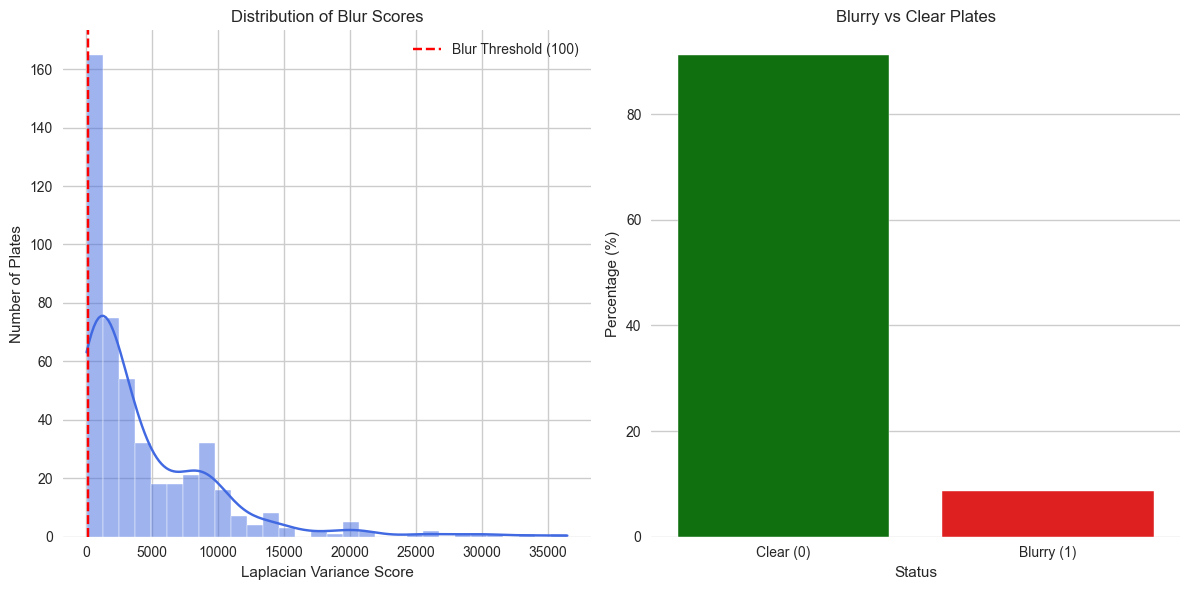


Blur Score Statistics:
- Mean: 4391.7
- Median: 2294.7
- Std Dev: 5507.1

Blurry Plates: 41 (8.7%)


In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect(db_path)
df = pd.read_sql_query("""
    SELECT blur_score, is_blurry 
    FROM engineered_plate_features
    WHERE blur_score IS NOT NULL
""", conn)
conn.close()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
sns.histplot(df['blur_score'], bins=30, kde=True, color='royalblue')
plt.axvline(x=100, color='red', linestyle='--', label='Blur Threshold (100)')
plt.title('Distribution of Blur Scores')
plt.xlabel('Laplacian Variance Score')
plt.ylabel('Number of Plates')
plt.legend()

plt.subplot(1, 2, 2)
blur_stats = df['is_blurry'].value_counts(normalize=True).mul(100).reset_index()
blur_stats.columns = ['blur_status', 'percentage']

sns.barplot(x='blur_status', y='percentage', hue='blur_status', 
            data=blur_stats, palette=['green', 'red'], 
            legend=False, order=[0, 1])
plt.title('Blurry vs Clear Plates')
plt.xlabel('Status')
plt.xticks([0, 1], ['Clear (0)', 'Blurry (1)'])
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()


print("\nBlur Score Statistics:")
print(f"- Mean: {df['blur_score'].mean():.1f}")
print(f"- Median: {df['blur_score'].median():.1f}")
print(f"- Std Dev: {df['blur_score'].std():.1f}")
print(f"\nBlurry Plates: {df['is_blurry'].sum()} ({df['is_blurry'].mean()*100:.1f}%)")

<a id='step18'></a>
### **Creating an AI Pipeline**

[Open Scripts folder from here](./scripts/)

In [30]:
import sys
import subprocess
import os

def run_script(script_path: str):
    print(f"\n▶️ Running {script_path}...")
    result = subprocess.run([sys.executable, script_path])
    if result.returncode != 0:
        print(f"❌ Script {script_path} failed with exit code {result.returncode}.")
        sys.exit(result.returncode)
    print(f"✅ Script {script_path} completed successfully.")
    

if __name__ == "__main__":
    scripts = [
        os.path.join('scripts', 'import_to_db.py'),
        os.path.join('scripts', 'feature_engineering.py'),
        os.path.join('scripts', 'preprocess.py'),
        os.path.join('scripts', 'run_detection_model.py'),
    ]
    for script in scripts:
        run_script(script)


    print("\n✅ Pipeline execution complete.")


▶️ Running scripts\import_to_db.py...
✅ Script scripts\import_to_db.py completed successfully.

▶️ Running scripts\feature_engineering.py...
❌ Script scripts\feature_engineering.py failed with exit code 1.


SystemExit: 1

[Opne README file from here](./README.md)


<a id='step19'></a>
### **General Overview of the Database**

In [31]:
import sqlite3

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("📋 Tables in database:")
for t in tables:
    print("-", t[0])


📋 Tables in database:
- car_plates
- engineeried_plate_features
- image_annotations
- engineered_detection_features
- engineered_plate_features


In [32]:
for table in ['engineered_plate_features', 'engineered_detection_features']:
    cursor.execute(f"PRAGMA table_info({table});")
    columns = cursor.fetchall()

    print(f"🧱 Columns in table '{table}':")
    for col in columns:
        print(f"  - {col[1]} ({col[2]})")

🧱 Columns in table 'engineered_plate_features':
  - filename (TEXT)
  - bbox_width (REAL)
  - bbox_height (REAL)
  - aspect_ratio (REAL)
  - area_fraction (REAL)
  - center_x_norm (REAL)
  - center_y_norm (REAL)
  - margin_top (REAL)
  - ocr_text (TEXT)
  - worth_ocr (REAL)
  - preprocessed_plate (TEXT)
  - plate_path (TEXT)
  - is_blurry (INTEGER)
  - blur_score (REAL)
🧱 Columns in table 'engineered_detection_features':
  - filename (TEXT)
  - xmin (REAL)
  - xmax (REAL)
  - ymin (REAL)
  - ymax (REAL)
  - image_path (TEXT)


In [ ]:
df_annotations = pd.read_sql_query("SELECT * FROM image_annotations LIMIT 5", conn)
df_features = pd.read_sql_query("SELECT * FROM engineered_plate_features LIMIT 5", conn)
df_fImages = pd.read_sql_query("SELECT * FROM engineered_detection_features LIMIT 5", conn)

conn.close()

In [ ]:
from IPython.display import display, Markdown

display(Markdown("### 📁 Sample: Plate Annotations"))
display(df_annotations.style.set_table_attributes('style="display:inline"').set_caption("Raw Bounding Box Info"))

display(Markdown("### 🧠 Sample: Engineered Plate Features"))
display(df_features.style.set_table_attributes('style="display:inline"').set_caption("Computed Features (Top 5 rows)"))

display(Markdown("### 🚗 Sample: Detection Features"))
display(df_fImages.style.set_table_attributes('style="display:inline"').set_caption("Computed Features (Top 5 rows)"))


### 📁 Sample: Plate Annotations

,filename,folder,width,height,xmin,ymin,xmax,ymax,ocr_text,worth_ocr,image_path
0,Cars339.png,images,500,300,209,135,283,169,nan,nan,content/images/Cars339.png
1,Cars423.png,images,400,250,162,159,283,183,nan,nan,content/images/Cars423.png
2,Cars5.png,images,400,295,226,218,242,240,nan,nan,content/images/Cars5.png
3,Cars369.png,images,500,400,176,253,325,280,nan,nan,content/images/Cars369.png
4,Cars119.png,images,400,247,187,140,217,153,[NO TEXT],0.000000,content/images/Cars119.png


### 🧠 Sample: Engineered Plate Features

,filename,bbox_width,bbox_height,aspect_ratio,area_fraction,center_x_norm,center_y_norm,margin_top,ocr_text,worth_ocr,preprocessed_plate,plate_path,is_blurry,blur_score
0,Cars339.png,0.132175,0.122827,0.116553,0.020707,0.327737,0.201309,100.800000,nan,nan,plate_0000.png,content/plates/plate_0000.png,0,3714.379138
1,Cars423.png,0.294892,0.100685,0.380060,0.055185,0.475872,0.453524,142.464000,nan,nan,plate_0001.png,content/plates/plate_0001.png,0,1891.146709
2,Cars5.png,0.018431,0.073317,0.006658,0.003998,0.502057,0.428336,165.532203,nan,nan,plate_0002.png,content/plates/plate_0002.png,0,472.069615
3,Cars369.png,0.290153,0.064278,0.560539,0.018535,0.334295,0.195705,141.680000,nan,nan,plate_0003.png,content/plates/plate_0003.png,0,50711.085641
4,Cars119.png,0.055292,0.045284,0.133564,0.006831,0.429196,0.372902,126.963563,[NO TEXT],0.000000,plate_0004.png,content/plates/plate_0004.png,0,148.353109


### 🚗 Sample: Detection Features

,filename,xmin,xmax,ymin,ymax,image_path
0,Cars339.png,93.632000,126.784000,100.800000,126.186667,content/detection_images/Cars339.png
1,Cars423.png,90.720000,158.480000,142.464000,163.968000,content/detection_images/Cars423.png
2,Cars5.png,126.560000,135.520000,165.532203,182.237288,content/detection_images/Cars5.png
3,Cars369.png,78.848000,145.600000,141.680000,156.800000,content/detection_images/Cars369.png
4,Cars119.png,104.720000,121.520000,126.963563,138.753036,content/detection_images/Cars119.png


<a id='step20'></a>
### **CI/CD  Implementation**

```yaml
name: CI/CD for project
'on':
  push:
    paths:
      - project/**
  pull_request:
    paths:
      - project/**
jobs:
  build:
    runs-on: ubuntu-latest
    steps:
      - name: Checkout code
        uses: actions/checkout@v3
      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: '3.12'
      - name: Install dependencies
        working-directory: ./project
        run: |
          python -m pip install --upgrade pip
          pip install -r requirements.txt
      - name: Run pipeline script
        working-directory: ./project
        run: |
          python3 pipeline.py
```

![Alt Text](git_hub_action_verification.png)

<a id='phase3'></a>
## **Phase 3 - Final Conclusions and Model Development**

### **Model Development (Detection)**

#### Model Selection: Faster R-CNN for License Plate Detection

The goal of this project is to detect license plates in car images using an object detection model that balances accuracy, robustness, and practicality for real-world deployment.
Faster R-CNN is a two-stage object detector that combines region proposal and classification in a unified, end-to-end trainable architecture. It has been selected due to the following reasons:

* **High Accuracy**: Excellent at detecting small objects like license plates.
* **Region Proposals**: Uses a Region Proposal Network (RPN) for better bounding box precision.
* **Well-Supported**: Available in PyTorch (`torchvision.models.detection`), making it easy to train.
* **Transfer Learning**: Pre-trained models accelerate development.

---

**Compared to Other Models:**

| Model        | Speed     | Accuracy | Small Object Detection |
| ------------ | --------- | -------- | ---------------------- |
| YOLO         |  Fast   |  Lower |  Weak                |
| SSD          |  Fast   |  Lower |  Weak                |
| Faster R-CNN |  Slower |  High   |  Strong               |

Faster R-CNN offers the best **accuracy and robustness** for our task, especially for **small and precise** targets like license plates — even if it's not the fastest.

#### Spliting the Data

We’ll split the annotated DataFrame (df) into training (70%), validation (15%), and test (15%) sets.

In [ ]:
from sklearn.model_selection import train_test_split
from scripts.load_data import load_detection_image_features

df = load_detection_image_features()
unique_filenames = df['filename'].unique()
unique_filenames = unique_filenames[["filename", "xmin", "ymin", "xmax", "ymax"]] # check 

train_files, temp_files = train_test_split(unique_filenames, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

df_train = df[df['filename'].isin(train_files)].reset_index(drop=True)
df_val = df[df['filename'].isin(val_files)].reset_index(drop=True)
df_test = df[df['filename'].isin(test_files)].reset_index(drop=True)

print(f"Train images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Test images: {len(test_files)}")

Train images: 303
Validation images: 65
Test images: 65


#### Defining a Custom Dataset Class

we can use it with a DataLoader for training Faster R-CNN.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image
import torch
import torchvision.transforms as T

class NumberPlateDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = df['filename'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
      image_id = self.image_ids[idx]
      records = self.df[self.df['filename'] == image_id]

      img_path = os.path.join(self.image_dir, image_id)
      image = Image.open(img_path).convert("RGB")

      if self.transform:
          image = self.transform(image)
      else:
          image = T.ToTensor()(image)

      boxes = []
      labels = []

      for _, row in records.iterrows():
          xmin = row['xmin']
          ymin = row['ymin']
          xmax = row['xmax']
          ymax = row['ymax']
          boxes.append([xmin, ymin, xmax, ymax])
          labels.append(1)

      boxes = torch.tensor(boxes, dtype=torch.float32)
      labels = torch.tensor(labels, dtype=torch.int64)

      target = {
          'boxes': boxes,
          'labels': labels,
          'image_id': torch.tensor([idx]),
          'filename': image_id
      }

      return image, target

In [ ]:
## Instantiate Datasets
train_dataset = NumberPlateDataset(df_train, image_folder)
val_dataset = NumberPlateDataset(df_val, image_folder)
test_dataset = NumberPlateDataset(df_test, image_folder)

img, target = train_dataset[0]
print(img.shape)
print(target)

torch.Size([3, 224, 224])
{'boxes': tensor([[ 90.7200, 142.4640, 158.4800, 163.9680]]), 'labels': tensor([1]), 'image_id': tensor([2010455874])}


#### Create DataLoaders with a Custom `collate_fn`

Faster R-CNN expects batches of data where:

* Each image can be a different size
* Each target is a dictionary (not a single tensor)

So we need a `collate_fn` to combine samples into a batch.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

#### Load and Customize the Faster R-CNN Model

We’ll load a pre-trained Faster R-CNN model and modify the **classification head** to match our dataset — in our case, there’s only **1 class: number plate**, plus background (so 2 total classes).

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# 2. Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 3. Replace the head with a new one (2 classes: background + number plate)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


#### Moving Model to Device (GPU if available)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

#### Seting up an optimizer

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

This is the setup used in the [official PyTorch object detection tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

We also add a Learning Rate Scheduler to decay the learning rate after some epochs:

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#### Evaluation Metrics: IoU and Detection Performance

##### Intersection over Union (IoU)

To evaluate the accuracy of predicted bounding boxes, we implemented the IoU metric, which measures the overlap between a predicted box and the ground truth box.

In [ ]:
def compute_iou(boxA, boxB):
    """
    Each box is defined as [x_min, y_min, x_max, y_max].
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = inter_area / float(boxA_area + boxB_area - inter_area + 1e-6)
    return iou

##### Matching Predictions to Ground Truth

For each predicted box, we compute its IoU with all ground truth boxes and match it to the one with the highest IoU (if above a threshold).

In [ ]:
def calculate_image_iou(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Matches predicted boxes to ground truth boxes and calculates IoU.

    Returns:
        matched_ious: List of IoUs for matched boxes
        num_correct: Number of predictions with IoU > threshold
    """
    matched_ious = []
    num_correct = 0
    matched_gt = set()

    for pred_box in pred_boxes:
        best_iou = 0.0
        best_gt_idx = -1
        for idx, gt_box in enumerate(gt_boxes):
            if idx in matched_gt:
                continue
            iou = compute_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou >= iou_threshold:
            matched_ious.append(best_iou)
            num_correct += 1
            matched_gt.add(best_gt_idx)

    return matched_ious, num_correct


#### Model Training and Evaluation

In [ ]:
import time
from tqdm import tqdm

def train_one_epoch(model, data_loader, optimizer, device, epoch, print_freq=50):
    model.train()
    epoch_loss = 0
    start_time = time.time()

    for i, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch}")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        for img in images:
            print(img.shape)
            break

        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        if (i + 1) % print_freq == 0:
            print(f"[Epoch {epoch} | Step {i + 1}] Loss: {total_loss.item():.4f}")



    avg_loss = epoch_loss / len(data_loader)
    print(f"\nEpoch {epoch} completed in {time.time() - start_time:.2f}s - Avg Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0.0
    total_gt_boxes = 0
    matched_gt_boxes = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

            outputs = model(images)

            for pred, gt in zip(outputs, targets):
                pred_boxes = pred['boxes'].cpu()
                gt_boxes = gt['boxes'].cpu()

                total_gt_boxes += len(gt_boxes)

                for gt_box in gt_boxes:
                    best_iou = 0.0
                    for pred_box in pred_boxes:
                        iou = compute_iou(gt_box.numpy(), pred_box.numpy())
                        best_iou = max(best_iou, iou)

                    total_iou += best_iou
                    if best_iou >= iou_threshold:
                        matched_gt_boxes += 1

    avg_iou = total_iou / total_gt_boxes
    detection_rate = matched_gt_boxes / total_gt_boxes
    print(f"\nEvaluation Results:")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Detection Rate @ IoU > {iou_threshold}: {detection_rate * 100:.2f}%")

    return avg_iou, detection_rate


Depending on your setup, you can choose between:

1. Training from scratch using the training loop (e.g., for fine-tuning or experimentation).
2. Loading a pre-trained model directly for evaluation or testing.

In [ ]:
# Training from scratch:
ious = []
detection_rates = []

num_epochs = 1  # change it to at least 10
for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, train_loader, optimizer, device, epoch)

    print(f"\nEvaluating after epoch {epoch}...")
    avg_iou, detection_rate = evaluate_model(model, val_loader, device)

    ious.append(avg_iou)
    detection_rates.append(detection_rate)

    # Step the learning rate scheduler
    lr_scheduler.step()

In [ ]:
model.load_state_dict(torch.load('models/detection_model.pth', map_location=torch.device('cuda')))

<All keys matched successfully>

#### Evaluation on Test Data

In [ ]:
device = torch.device('cuda')
model.to(device)
print("Final evaluation on test data...")
test_avg_iou, test_detection_rate = evaluate_model(model, test_loader, device)

print(f"\nTest Results:\n- Average IoU: {test_avg_iou:.4f}\n- Detection Rate: {test_detection_rate:.4f}")

Final evaluation on test data...


Evaluating:  27%|██▋       | 9/33 [00:10<00:28,  1.20s/it]


KeyboardInterrupt: 

#### Plot IoU and Detection Rate

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, ious, label='Average IoU', marker='o')
plt.plot(epochs, detection_rates, label='Detection Rate', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'num_epochs' is not defined

#### Visualizing 5 Random Test Predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import torchvision.transforms.functional as F
import torch
import math

def visualize_predictions(model, dataset, device, num_images=9, score_threshold=0.5):
    """
    Visualizes predictions from the model on random samples from the dataset.
    Displays all selected images in a grid of subplots.
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    cols = min(num_images, 3) 
    rows = math.ceil(num_images / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten() if num_images > 1 else [axs]

    for ax, idx in zip(axs, indices):
        image, target = dataset[idx]
        img_tensor = image.to(device).unsqueeze(0)

        with torch.no_grad():
            prediction = model(img_tensor)[0]

        img = image.cpu()
        img = F.to_pil_image(img)
        ax.imshow(img)
        ax.set_title(f"Image #{idx}")
        ax.axis('off')

        for box in target['boxes']:
            x_min, y_min, x_max, y_max = box
            width, height = x_max - x_min, y_max - y_min
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, 'GT', color='green', fontsize=8, weight='bold')

        for box, score in zip(prediction['boxes'], prediction['scores']):
            if score >= score_threshold:
                x_min, y_min, x_max, y_max = box.cpu()
                width, height = x_max - x_min, y_max - y_min
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min - 5, f"Pred ({score:.2f})", color='red', fontsize=8, weight='bold')

    for i in range(num_images, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


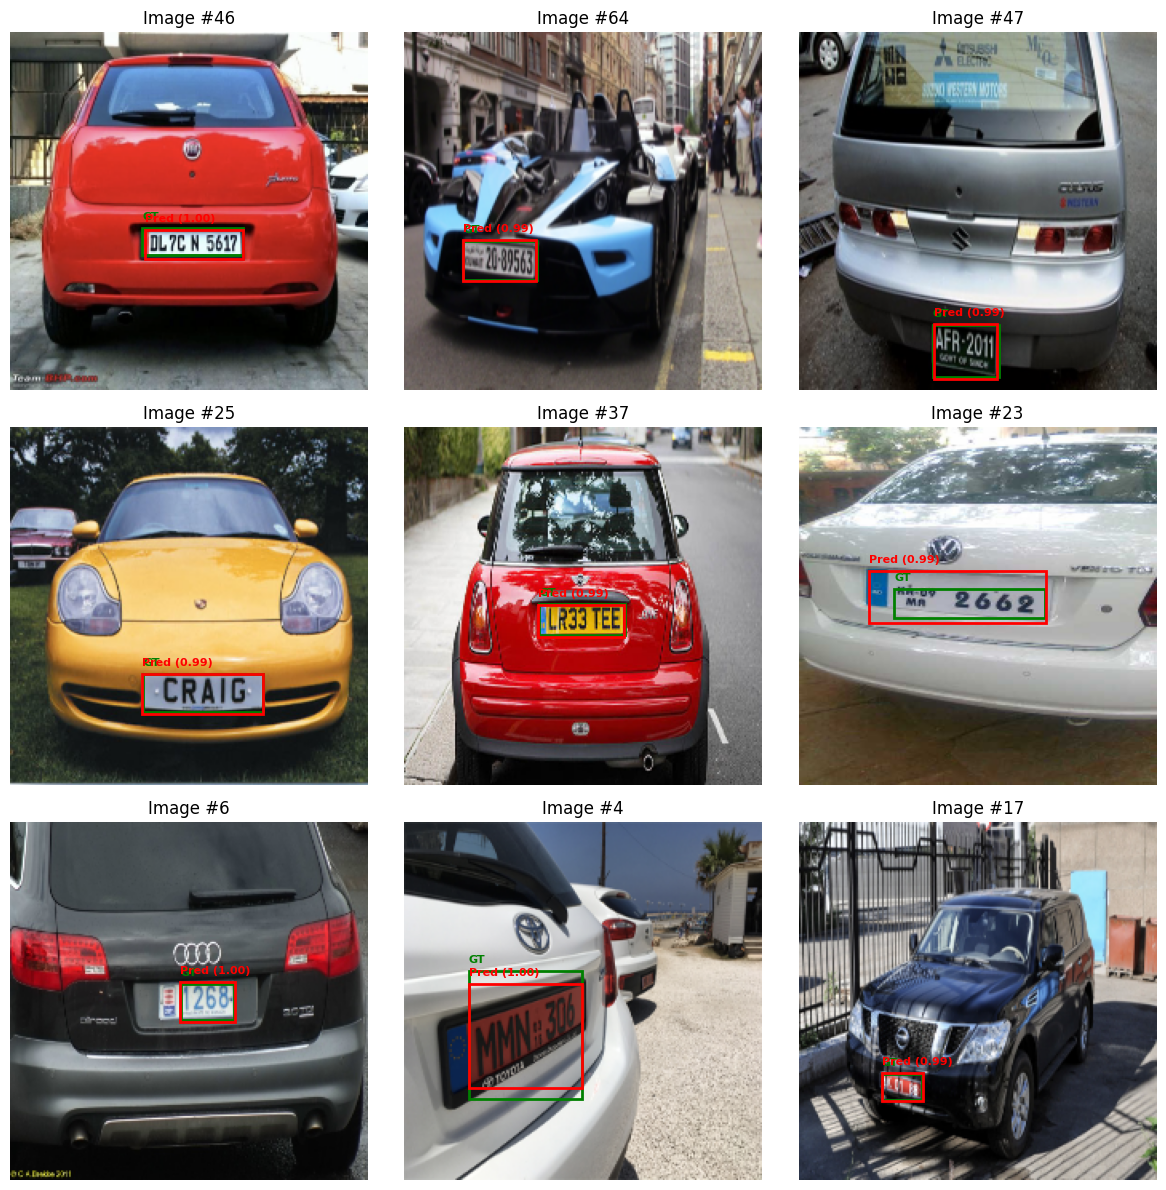

In [ ]:
visualize_predictions(model, test_dataset, device, score_threshold=0.5)

#### Saving the Predicted Bounding Boxes

In [ ]:
model.eval()

all_predictions = {}

with torch.no_grad():
    for idx, (images, targets) in enumerate(test_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            image_id = targets[i]["image_id"].item()

            boxes = output["boxes"].cpu().numpy().tolist()
            scores = output["scores"].cpu().numpy().tolist()
            labels = output["labels"].cpu().numpy().tolist()

            threshold = 0.5
            filtered = [
                {
                    "box": box,
                    "score": score,
                    "label": label
                }
                for box, score, label in zip(boxes, scores, labels)
                if score > threshold
            ]

            all_predictions[image_id] = filtered

In [ ]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

def create_xml_annotation(filename, width, height, boxes, save_dir="predicted_annotations"):
    os.makedirs(save_dir, exist_ok=True)

    annotation = ET.Element("annotation")

    ET.SubElement(annotation, "folder").text = "images"
    ET.SubElement(annotation, "filename").text = filename

    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"

    ET.SubElement(annotation, "segmented").text = "0"

    for box in boxes:
        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = "licence"
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = "0"
        ET.SubElement(obj, "occluded").text = "0"
        ET.SubElement(obj, "difficult").text = "0"

        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(int(box[0]))
        ET.SubElement(bndbox, "ymin").text = str(int(box[1]))
        ET.SubElement(bndbox, "xmax").text = str(int(box[2]))
        ET.SubElement(bndbox, "ymax").text = str(int(box[3]))

    rough_string = ET.tostring(annotation, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    pretty_xml = reparsed.toprettyxml(indent="  ")

    xml_filename = os.path.join(save_dir, filename.replace('.png', '.xml'))
    with open(xml_filename, 'w') as f:
        f.write(pretty_xml)

    print(f"Saved: {xml_filename}")


model.eval()
all_predictions = {}

with torch.no_grad():
    for idx, (images, targets) in enumerate(test_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            boxes = output["boxes"].cpu().numpy().tolist()
            scores = output["scores"].cpu().numpy().tolist()

            threshold = 0.5
            filtered_boxes = [
                box for box, score in zip(boxes, scores) if score > threshold
            ]

            filename = targets[i]["filename"]
            width = images[i].shape[2]
            height = images[i].shape[1]

            create_xml_annotation(filename, width, height, filtered_boxes)

Saved: predicted_annotation/Cars339.xml
Saved: predicted_annotation/Cars236.xml
Saved: predicted_annotation/Cars51.xml
Saved: predicted_annotation/Cars203.xml
Saved: predicted_annotation/Cars197.xml
Saved: predicted_annotation/Cars99.xml
Saved: predicted_annotation/Cars119.xml
Saved: predicted_annotation/Cars96.xml
Saved: predicted_annotation/Cars420.xml
Saved: predicted_annotation/Cars3.xml
Saved: predicted_annotation/Cars268.xml
Saved: predicted_annotation/Cars202.xml
Saved: predicted_annotation/Cars256.xml
Saved: predicted_annotation/Cars342.xml
Saved: predicted_annotation/Cars358.xml
Saved: predicted_annotation/Cars302.xml
Saved: predicted_annotation/Cars0.xml
Saved: predicted_annotation/Cars163.xml
Saved: predicted_annotation/Cars367.xml
Saved: predicted_annotation/Cars317.xml
Saved: predicted_annotation/Cars254.xml
Saved: predicted_annotation/Cars327.xml
Saved: predicted_annotation/Cars209.xml
Saved: predicted_annotation/Cars316.xml
Saved: predicted_annotation/Cars374.xml
Saved: 

### **Model Development (OCR)**

### **Predict ocr_worth**:
using data from phase 2 we can predict if a picture is good enough to use ocr on

In [6]:
import pandas as pd
import sqlite3
import os
import joblib
from scripts.load_data import load_plate_features
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

train_mode = True 
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

db_path = os.path.join("database", "dataset.db")

conn = sqlite3.connect(db_path)
df1 = load_plate_features()
df = df1.dropna(subset=['worth_ocr'])

features = ['blur_score', 'bbox_width', 'bbox_height', 'aspect_ratio', 'area_fraction']
X = df[features]
y = df['worth_ocr']

model_defs = {
    'random_forest': RandomForestClassifier(),
    'log_reg': LogisticRegression(max_iter=1000),
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

if train_mode:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    for name, model in model_defs.items():
        print(f"\n🧠 Training: {name}")
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print(f"📊 {name} performance:")
        print(classification_report(y_test, preds, zero_division=1))
        joblib.dump(model, os.path.join(model_dir, f"{name}.pkl"))

    print("✅ All models trained and saved.\n")

else:
    all_model_preds = []
    df_preds = df[['preprocessed_plate']].copy()

    for model_name in model_defs.keys():
        model_path = os.path.join(model_dir, f"{model_name}.pkl")
        if not os.path.exists(model_path):
            print(f"❌ Skipping {model_name}: model not found.")
            continue

        print(f"📥 Loading {model_name} model...")
        model = joblib.load(model_path)
        preds = model.predict(X)
        df_preds[f'{model_name}_prediction'] = preds

        if hasattr(model, 'predict_proba'):
            confs = model.predict_proba(X)[:, 1]
            df_preds[f'{model_name}_conf'] = confs

    df_preds.to_csv("predicted_worth_ocr_all_models.csv", index=False)
    print("✅ All predictions saved to predicted_worth_ocr_all_models.csv")





🧠 Training: random_forest
📊 random_forest performance:
              precision    recall  f1-score   support

         0.0       0.81      0.57      0.67        23
         1.0       0.89      0.97      0.93        86

    accuracy                           0.88       109
   macro avg       0.85      0.77      0.80       109
weighted avg       0.88      0.88      0.87       109


🧠 Training: log_reg
📊 log_reg performance:
              precision    recall  f1-score   support

         0.0       1.00      0.00      0.00        23
         1.0       0.79      1.00      0.88        86

    accuracy                           0.79       109
   macro avg       0.89      0.50      0.44       109
weighted avg       0.83      0.79      0.70       109


🧠 Training: xgboost
📊 xgboost performance:
              precision    recall  f1-score   support

         0.0       0.68      0.57      0.62        23
         1.0       0.89      0.93      0.91        86

    accuracy                          

### **EasyOCR & TROCR**:
trocr and easyocr were used predict the text on plates.

In [7]:
import os
import sqlite3
import pandas as pd
import cv2
import easyocr
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
easy_reader = easyocr.Reader(['en'], gpu=False)
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1").eval()

def normalize_text(text):
    replacements = {
        'o': '0', 'O': '0', 'Q': '0','.':'0',
        'l': '1', 'I': '1', ']': '1', '|': '1',
        'S': '5', 's': '5',
        'Z': '2', 'B': '8',
        ' ': '', '\n': '', '-': '', '.': ''
    }
    for k, v in replacements.items():
        text = text.replace(k, v).replace(k.upper(), v)
    return text.strip()

def easyocr_predict(img):
    result = easy_reader.readtext(img)
    return result[0][1] if result else "[NO TEXT]"

def trocr_predict(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = trocr_processor(images=image, return_tensors="pt").pixel_values
        ids = trocr_model.generate(inputs)
        return trocr_processor.batch_decode(ids, skip_special_tokens=True)[0]
    except:
        return "[NO TEXT]"
    


def run_ensemble():
    conn = sqlite3.connect("database/dataset.db")
    df = pd.read_sql_query("""
        SELECT preprocessed_plate, plate_path, ocr_text
        FROM engineered_plate_features
        WHERE preprocessed_plate IS NOT NULL AND plate_path IS NOT NULL
              AND ocr_text IS NOT NULL AND ocr_text != '[NO TEXT]'
    """, conn)
    conn.close()

    print(f"🔎 Loaded {len(df)} plate entries from DB")

    results = []
    for i, row in enumerate(df.itertuples(), start=1):
        img_path = row.plate_path
        if not os.path.exists(img_path):
            print(f"⚠️ Skipping missing: {img_path}")
            continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"❌ Failed to load: {img_path}")
            continue

        easy_text = easyocr_predict(image)
        troc_text = trocr_predict(img_path)

        results.append({
            "preprocessed_plate": row.preprocessed_plate,
            "plate_path": row.plate_path,
            "ocr_text": row.ocr_text,
            "easyocr_text": easy_text,
            "trocr_text": troc_text
        })

        if i % 10 == 0:
            print(f"🚀 Processed {i}/{len(df)} entries...")

    df_pred = pd.DataFrame(results)
    df_pred.to_csv("content/ocr_ensemble_results.csv", index=False)
    print("✅ Saved predictions to ocr_ensemble_results.csv")
    return df_pred


df_pred=run_ensemble()

Using CPU. Note: This module is much faster with a GPU.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔎 Loaded 373 plate entries from DB


C:\Users\manih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🚀 Processed 10/373 entries...
🚀 Processed 20/373 entries...
🚀 Processed 30/373 entries...
🚀 Processed 40/373 entries...
🚀 Processed 50/373 entries...
🚀 Processed 60/373 entries...
🚀 Processed 70/373 entries...
🚀 Processed 80/373 entries...
🚀 Processed 90/373 entries...
🚀 Processed 100/373 entries...
🚀 Processed 110/373 entries...
🚀 Processed 120/373 entries...
🚀 Processed 130/373 entries...
🚀 Processed 140/373 entries...
🚀 Processed 150/373 entries...
🚀 Processed 160/373 entries...
🚀 Processed 170/373 entries...
🚀 Processed 180/373 entries...
🚀 Processed 190/373 entries...
🚀 Processed 200/373 entries...
🚀 Processed 210/373 entries...
🚀 Processed 220/373 entries...
🚀 Processed 230/373 entries...
🚀 Processed 240/373 entries...
🚀 Processed 250/373 entries...
🚀 Processed 260/373 entries...
🚀 Processed 270/373 entries...
🚀 Processed 280/373 entries...
🚀 Processed 290/373 entries...
🚀 Processed 300/373 entries...
🚀 Processed 310/373 entries...
🚀 Processed 320/373 entries...
🚀 Processed 330/3

### **Evaluate OCR**:
leveshtein and accuracy were used to evaluate the predicted text.

In [ ]:
import Levenshtein
OCR_EVAL_PATH = os.path.join('content', 'ocr_evaluation_detailed.csv')
def evaluate(df_pred):
    for method in ['easyocr', 'trocr']:
        pred_col = f"{method}_text"

        df_pred[f'{method}_exact'] = df_pred[pred_col] == df_pred['ocr_text']
        df_pred[f'{method}_norm'] = df_pred.apply(
            lambda row: normalize_text(row[pred_col]) == normalize_text(row['ocr_text']), axis=1)
        df_pred[f'{method}_lev'] = df_pred.apply(
            lambda row: Levenshtein.distance(normalize_text(row['ocr_text']), normalize_text(row[pred_col])), axis=1)

        print(f"\n📊 Evaluation for {method.upper()}")
        print(f" - Exact Match       : {df_pred[f'{method}_exact'].mean():.2f}")
        print(f" - Normalized Match  : {df_pred[f'{method}_norm'].mean():.2f}")
        print(f" - Avg Levenshtein   : {df_pred[f'{method}_lev'].mean():.2f}")
        df_pred[f'{method}_lev_ratio'] = df_pred.apply(
            lambda row: Levenshtein.ratio(normalize_text(row['ocr_text']), normalize_text(row[pred_col])), axis=1)
        
        df_pred[f'{method}_char_acc'] = df_pred.apply(
            lambda row: 1 - Levenshtein.distance(normalize_text(row['ocr_text']), normalize_text(row[pred_col])) / max(len(normalize_text(row['ocr_text'])), 1), axis=1)
        print(f" - Avg Levenshtein Ratio {method}  : {df_pred[f'{method}_lev_ratio'].mean():.2f}")
        print(f" - Avg Character Accuracy {method} : {df_pred[f'{method}_char_acc'].mean():.2f}")

    df_pred['correct_label'] = df_pred['ocr_text']
    df_pred['wrong_label'] = df_pred.apply(lambda row: row['easyocr_text'] if not row['easyocr_exact'] else row['trocr_text'] if not row['trocr_exact'] else None, axis=1)

    print("\n🔍 5 Incorrect Labels:")
    print(df_pred[df_pred['wrong_label'].notna() & (df_pred['ocr_text'] != "nan")][['plate_path', 'ocr_text', 'wrong_label']][:5])

    df_pred.to_csv(OCR_EVAL_PATH, index=False)
    print("📈 Evaluation details saved to ocr_evaluation_detailed.csv")


evaluate(df_pred)


📊 Evaluation for EASYOCR
 - Exact Match       : 0.13
 - Normalized Match  : 0.22
 - Avg Levenshtein   : 3.19
 - Avg Levenshtein Ratio easyocr  : 0.63
 - Avg Character Accuracy easyocr : 0.41

📊 Evaluation for TROCR
 - Exact Match       : 0.26
 - Normalized Match  : 0.50
 - Avg Levenshtein   : 1.68
 - Avg Levenshtein Ratio trocr  : 0.77
 - Avg Character Accuracy trocr : 0.67

🔍 5 Incorrect Labels:
                      plate_path       ocr_text    wrong_label
0  content\plates\plate_0000.png     KLG1CA2555     KLCACA2555
1  content\plates\plate_0001.png       PGoMN112       PG.MN112
2  content\plates\plate_0004.png  HR 26 BC 55I4  HR 26 BC 5514
3  content\plates\plate_0005.png        6861136       6861/*36
5  content\plates\plate_0010.png        NL60LXB         MeoLwB
📈 Evaluation details saved to ocr_evaluation_detailed.csv
